In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from sklearn import preprocessing
import random
import json
import os

In [2]:
style.use('seaborn-white')

# Initialise small 2 district model

In [3]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [32]:
parameters = {
    # general simulation parameters
    "time": 60,
    "number_of_agents": 300,
    "monte_carlo_runs": 1,
    "data_output": 'network', # 'csv' or 'network', or 'False'
    # specific simulation parameters
    "incubation_days": 5, # average number of days agents are infected but do not have symptoms SOURCE Zhang et al. 2020
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 8, # average number of days agents are in critical condition
    "health_system_capacity": 0.0021, # relative (in terms of population) capacity of the hospitals
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "travel_sample_size": 0.02, # amount of agents that an agent might choose to travel to
    "foreign_infection_days": [x for x in range(0, 2)], # days at which 1 agent will be infected every day from abroad 
    # agent parameters
    "probability_transmission": 0.09, # should be estimated to replicate realistic R0 number.
    "probability_to_travel": 0.25, # should be estimated to replicate travel data 
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, # probability to die per age group in critical stage SOURCE: Verity et al.
    "probability_susceptible": 0.000, # probability that the agent will again be susceptible after having recovered
    # experiment parameter
    "lockdown_days" : [x for x in range(0, 60)], # in the baseline this is 0, 5 march was the first reported case, 27 march was the start of the lockdown 35 days
    "lockdown_travel_multiplier": 1.0 - ((0.85 + 0.62) / 2), # need estimate for this based on apple travel data reduction of 85% google work of -62% for Western Cape
    "lockdown_infection_multiplier": 0.27, #0.27 Jarvis et al. 2020
    "lockdown_travel_max_contacts": 4,
    "informality_dummy": 0.0, # setting this parameter at 0 will mean the lockdown is equally effective anywhere, alternative = 1
    "at_risk_groups": age_groups # list all age groups for baseline
}

In [23]:
districts_data = [[1, {'Population': round(parameters['number_of_agents'] / 2),
                                                 'Density': 1.0,
                                                 'lon': 1.0,
                                                 'lat': 1.0,
                                                 'Informal_residential': 0.0,
                                                 'Cases_With_Subdistricts': 0.5,
                                                }],
                 [2, {'Population': round(parameters['number_of_agents'] / 2),
                                                 'Density': 1.0,
                                                 'lon': 2.0,
                                                 'lat': 2.0,
                                                 'Informal_residential': 0.0,
                                                 'Cases_With_Subdistricts': 0.5,
                                                }]]

In [24]:
a_distribution =  [0.112314, 0.118867, 0.145951, 0.145413, 0.151773, 0.139329, 0.099140, 0.058729, 0.028484]

Age distribution per district only has one district and accompanying distribution. 

In [25]:
age_distribution_per_district = {1: pd.Series(a_distribution, index=age_groups), 2: pd.Series(a_distribution, index=age_groups)}

The distance matrix is assumes that there is an equal opportunity for tavel between and within the two districts

In [26]:
travel_matrix = {districts_data[0][0]: [0.5, 0.5], districts_data[1][0]: [0.5, 0.5]}
travel_matrix = pd.DataFrame(travel_matrix).transpose()
travel_matrix.columns = [districts_data[0][0], districts_data[1][0]]

In [27]:
travel_matrix

,1,2
1,0.5,0.5
2,0.5,0.5


In [28]:
distance_matrix = distance_matrix = {districts_data[0][0]: [0.0, 1.5], districts_data[1][0]: [1.5, 0.0]}
distance_matrix = pd.DataFrame(distance_matrix).transpose()
distance_matrix.columns = [districts_data[0][0], districts_data[1][0]]

In [29]:
distance_matrix

,1,2
1,0.0,1.5
2,1.5,0.0


In [30]:
data_folder = 'measurement/simple/'

if not os.path.exists('{}seed{}'.format(data_folder, 0)):
    os.makedirs('{}seed{}'.format(data_folder, 0))

# Interactive simulation

In [33]:
@interact
def simulate_model(transmission_probability=(0.0, 0.1, 0.05), max_contacts=(0, 20, 1),
                   lockdown=['phase5', 'phase4', 'phase3', 'phase2', 'phase1']):
    parameters['probability_transmission'] = transmission_probability
    parameters['lockdown_days'] = [0 for x in range(0, 60)]
    lockdown_effect = {'phase5': 0.27, 'phase4': 0.30, 'phase3': 0.40, 'phase2': 0.50, 'phase1': 0.66}
    print('assumed % of interactions', lockdown_effect)
    print()
    parameters["lockdown_infection_multiplier"] = lockdown_effect[lockdown]
    
    parameters['lockdown_travel_max_contacts'] = max_contacts
    
    #acti_effect_lockdown = {'phase5': -0.8, 'phase4': -0.7, 'phase3': -0.6, 'phase2': -0.5, 'phase1': -0.4}
    # simulate baseline
    
    environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)
    environment = runner(environment, 0, data_folder=data_folder, data_output=parameters["data_output"], travel_matrix=travel_matrix)
    
    for idx, network in enumerate(environment.infection_states):
        for i, node in enumerate(network.nodes):
            network.nodes[i]['agent'] = network.nodes[i]['agent'].status
            
    susceptible_ot = []
    infected_1_ot = []
    infected_2_ot = []
    critical_ot = []
    dead_ot = []
    recovered_ot = []

    for t in range(parameters['time']):
        network = environment.infection_states[t]
        susceptible = 0
        infected_1 = 0
        infected_2 = 0
        critical = 0
        dead = 0
        recovered = 0
        for idx, node in enumerate(network):
            if network.nodes[idx]['agent'] == 's':
                susceptible += 1
            elif network.nodes[idx]['agent'] == 'i1':
                infected_1 += 1
            elif network.nodes[idx]['agent'] == 'i2':
                infected_2 += 1
            elif network.nodes[idx]['agent'] == 'c':
                critical += 1
            elif network.nodes[idx]['agent'] == 'd':
                dead += 1
            elif network.nodes[idx]['agent'] == 'r':
                recovered +=1
            else:
                print('no status?')

        susceptible_ot.append((susceptible / float(len(network))))
        infected_1_ot.append((infected_1 / float(len(network))))
        infected_2_ot.append((infected_2 / float(len(network))))
        critical_ot.append((critical / float(len(network))))
        dead_ot.append((dead / float(len(network))))
        recovered_ot.append((recovered / float(len(network))))
            
    # simulate lockdown 
    parameters['lockdown_days'] = [x for x in range(0, 46)]
    
    environment_l = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)
    environment_l = runner(environment_l, 0, data_folder=data_folder, data_output=parameters["data_output"], travel_matrix=travel_matrix)
    
    for idx, network_l in enumerate(environment_l.infection_states):
        for i, node in enumerate(network_l.nodes):
            network_l.nodes[i]['agent'] = network_l.nodes[i]['agent'].status
            
    susceptible_ot_l = []
    infected_1_ot_l = []
    infected_2_ot_l = []
    critical_ot_l = []
    dead_ot_l = []
    recovered_ot_l = []

    for t in range(parameters['time']):
        network = environment_l.infection_states[t]
        susceptible = 0
        infected_1 = 0
        infected_2 = 0
        critical = 0
        dead = 0
        recovered = 0
        for idx, node in enumerate(network):
            if network.nodes[idx]['agent'] == 's':
                susceptible += 1
            elif network.nodes[idx]['agent'] == 'i1':
                infected_1 += 1
            elif network.nodes[idx]['agent'] == 'i2':
                infected_2 += 1
            elif network.nodes[idx]['agent'] == 'c':
                critical += 1
            elif network.nodes[idx]['agent'] == 'd':
                dead += 1
            elif network.nodes[idx]['agent'] == 'r':
                recovered +=1
            else:
                print('no status?')

        susceptible_ot_l.append((susceptible / float(len(network))))
        infected_1_ot_l.append((infected_1 / float(len(network))))
        infected_2_ot_l.append((infected_2 / float(len(network))))
        critical_ot_l.append((critical / float(len(network))))
        dead_ot_l.append((dead / float(len(network))))
        recovered_ot_l.append((recovered / float(len(network))))
    
    
    # plot figure
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

    x = [x for x in range(parameters['time'])]

    labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

    y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

    ax1.axhline(parameters['health_system_capacity'], color='black')

    pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

    ax1.stackplot(x, y, colors= pal, labels=labels)
    ax1.legend(loc='best', fontsize='14', frameon=True)
    ax1.set_ylabel('Cape Town population', fontsize='14')
    
    y2 = np.vstack([critical_ot_l, infected_2_ot_l, infected_1_ot_l, recovered_ot_l, susceptible_ot_l, dead_ot_l])
    ax2.stackplot(x, y2, colors= pal, labels=labels)
    
    for ax in [ax1, ax2]:
        ax1.set_xlabel('Days', fontsize='14')
        
    columns = ['total dead', 'peak critical', 'total recovered']
    experiment_summary = {'1 baseline': [dead_ot[-1], max(critical_ot), recovered_ot[-1]],
                      '1 (relative)': [100, 100, 100],
                      '2 {}'.format(lockdown): [dead_ot_l[-1], max(critical_ot_l), recovered_ot_l[-1]],
                      '2 (relative)': [dead_ot_l[-1] / dead_ot[-1], max(critical_ot_l) / max(critical_ot), recovered_ot_l[-1] / recovered_ot[-1]]
                     }
    experiment_summary = pd.DataFrame(experiment_summary).transpose()
    experiment_summary.columns = columns
    
    print(experiment_summary.round(2))


interactive(children=(FloatSlider(value=0.05, description='transmission_probability', max=0.1, step=0.05), Int…

# Simulation

In [14]:
data_folder = 'measurement/simple/'

if not os.path.exists('{}seed{}'.format(data_folder, 0)):
    os.makedirs('{}seed{}'.format(data_folder, 0))
    
environment = Environment(0, parameters, districts_data, age_distribution_per_district, distance_matrix)
environment = runner(environment, 0, data_output='network', data_folder=data_folder, travel_matrix=travel_matrix)

# Analysis

In [15]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

In [16]:
pos = nx.spring_layout(environment.infection_states[0])

In [17]:
def plot_model(t):
    network = environment.infection_states[t]
    color_map = []
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            color_map.append('blue')
        elif network.nodes[idx]['agent'] == 'i1':
            color_map.append('pink')
        elif network.nodes[idx]['agent'] == 'i2':
            color_map.append('red')
        elif network.nodes[idx]['agent'] == 'c':
            color_map.append('brown')
        elif network.nodes[idx]['agent'] == 'd':
            color_map.append('black')
        elif network.nodes[idx]['agent'] == 'r':
            color_map.append('grey')
    nx.draw(network, pos=pos, node_color=color_map, with_labels=True)

In [18]:
time_period = wg.IntSlider(description='Time step', min=0, max=parameters['time']-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=59), Output()), _dom_classes=('widget-in…

<function __main__.plot_model(t)>

In [21]:
susceptible_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(parameters['time']):
    network = environment.infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append((susceptible / float(len(network))))
    infected_1_ot.append((infected_1 / float(len(network))))
    infected_2_ot.append((infected_2 / float(len(network))))
    critical_ot.append((critical / float(len(network))))
    dead_ot.append((dead / float(len(network))))
    recovered_ot.append((recovered / float(len(network))))

(0, 1)

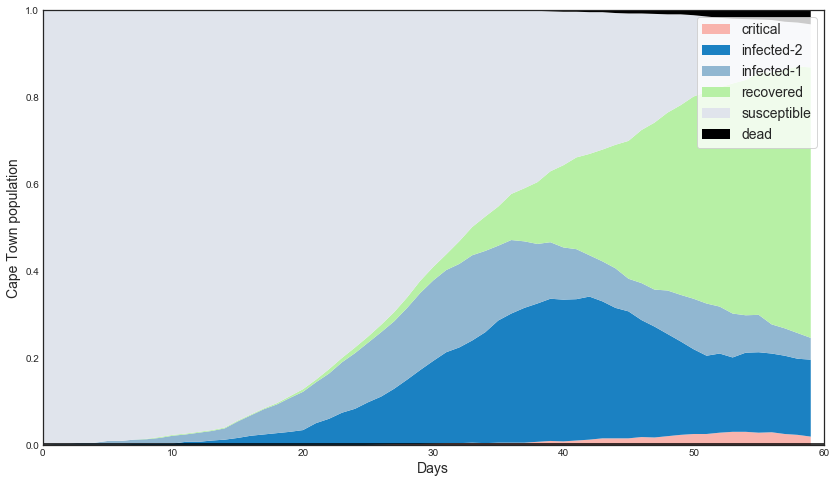

In [22]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(parameters['health_system_capacity'], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

plt.xlim([0,parameters['time']])
plt.ylim([0, 1])

#fig.savefig('measurement/the_curve.png')